In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

pd.options.display.max_columns = 120


In [2]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

In [3]:
train_dir = Path("../datasets/NR_split_on_skiers/train_val") 
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path("../datasets/NR_split_on_skiers/test")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}")     

Training files: 10
Test files: 2


In [4]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']
output_col = "Gear"
feature_columns = feature_columns_pole_data + feature_columns_gnss

In [5]:
dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]

def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]

In [6]:
def _stable_indices(y, n=2):
    """Return positional indices where the label has been stable for n before and n after."""
    y = y.reset_index(drop=True)
    idx = []
    for i in range(n, len(y) - n):
        c = y.iloc[i]
        # use iloc for positional comparisons
        if all(y.iloc[i - j] == c and y.iloc[i + j] == c for j in range(1, n + 1)):
            idx.append(i)
    return idx

def accuracy_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return np.nan
    return np.mean(y.iloc[idx].values == pred[idx])

def classification_report_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return "No stable segments found."
    return classification_report(y.iloc[idx], pred[idx], labels=ALL_LABELS, zero_division=0)

def confusion_matrix_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return None
    return confusion_matrix(y.iloc[idx], pred[idx], labels=ALL_LABELS)

In [7]:
train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")

Training data shape: (11271, 21)
Test data shape: (2419, 21)


In [8]:
def XY(df, feature_columns):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y

In [9]:
feature_columns = feature_columns_pole_data + feature_columns_gnss
X_train, y_train = XY(train_df, feature_columns)
X_test, y_test = XY(test_df, feature_columns)

In [10]:
def make_window_for_cnn(X, y, window_size=5):
    half_window = window_size // 2
    X_padded = np.pad(X, ((half_window, half_window), (0, 0)), mode='edge')
    X_windows = np.array([X_padded[i:i + window_size] for i in range(len(X))])
    return X_windows, y.values

In [11]:
X_train_seq, y_train_seq = make_window_for_cnn(X_train.values, y_train, window_size=5)
X_test_seq, y_test_seq = make_window_for_cnn(X_test.values, y_test, window_size=5)

In [12]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_seq)
y_test_enc  = le.transform(y_test_seq)

n_classes  = len(le.classes_)
n_features = X_train_seq.shape[-1]

In [13]:
def make_cnn(window, n_features, n_classes):
    inp = layers.Input(shape=(window, n_features))   # (T, F)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)          # downsample time

    x = layers.Conv1D(128, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = make_cnn(5, n_features, n_classes)

es = callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')
rlr = callbacks.ReduceLROnPlateau(patience=4, factor=0.5)

history = model.fit(
    X_train_seq, y_train_enc,
    validation_split=0.15,  # (or GroupKFold to avoid skier leakage)
    epochs=60, batch_size=256,
    callbacks=[es, rlr], 
    verbose=1
)

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7385 - loss: 0.7144 - val_accuracy: 0.6162 - val_loss: 1.3508 - learning_rate: 0.0010
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8291 - loss: 0.4703 - val_accuracy: 0.5920 - val_loss: 1.1686 - learning_rate: 0.0010
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8498 - loss: 0.4107 - val_accuracy: 0.5565 - val_loss: 1.0400 - learning_rate: 0.0010
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8586 - loss: 0.3814 - val_accuracy: 0.5795 - val_loss: 0.9153 - learning_rate: 0.0010
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.3468 - val_accuracy: 0.6546 - val_loss: 0.8079 - learning_rate: 0.0010
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8835 - loss: 0.3134 - val_accuracy: 0.6529 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 7/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8851 - loss: 0.2939 - val_accuracy: 

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
CNN — Train
              precision    recall  f1-score   support

         0.0      0.920     0.750     0.827      2247
        2.0H      0.902     0.775     0.833      1118
        2.0V      0.966     0.769     0.857       559
         3.0      0.820     0.985     0.895      5872
         4.0      0.864     0.573     0.689      1475

    accuracy                          0.853     11271
   macro avg      0.894     0.770     0.820     11271
weighted avg      0.861     0.853     0.846     11271



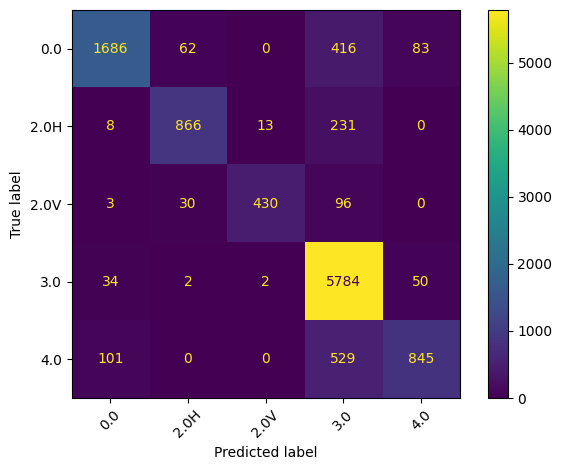

Stable gears (CNN) — Train
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86      1830
        2.0H       0.90      0.86      0.88       959
        2.0V       0.98      0.86      0.91       473
         3.0       0.86      1.00      0.92      5245
         4.0       0.94      0.65      0.76      1062

    accuracy                           0.89      9569
   macro avg       0.93      0.83      0.87      9569
weighted avg       0.90      0.89      0.89      9569



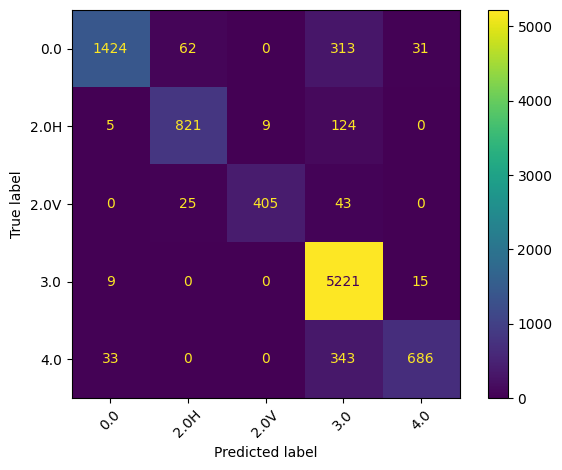

CNN — Test
              precision    recall  f1-score   support

         0.0      0.888     0.875     0.881       391
        2.0H      0.955     0.886     0.919       193
        2.0V      1.000     0.740     0.850       173
         3.0      0.864     0.985     0.921      1431
         4.0      0.768     0.316     0.448       231

    accuracy                          0.878      2419
   macro avg      0.895     0.760     0.804      2419
weighted avg      0.876     0.878     0.864      2419



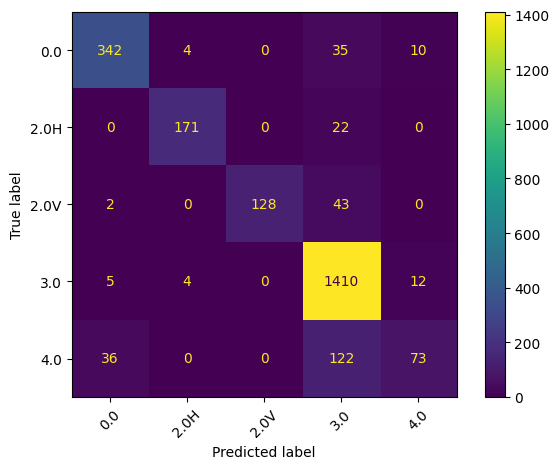

Stable gears (CNN) — Test
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       311
        2.0H       0.99      0.94      0.97       174
        2.0V       1.00      0.88      0.93       146
         3.0       0.92      0.99      0.96      1315
         4.0       0.87      0.36      0.51       126

    accuracy                           0.93      2072
   macro avg       0.94      0.82      0.86      2072
weighted avg       0.93      0.93      0.92      2072



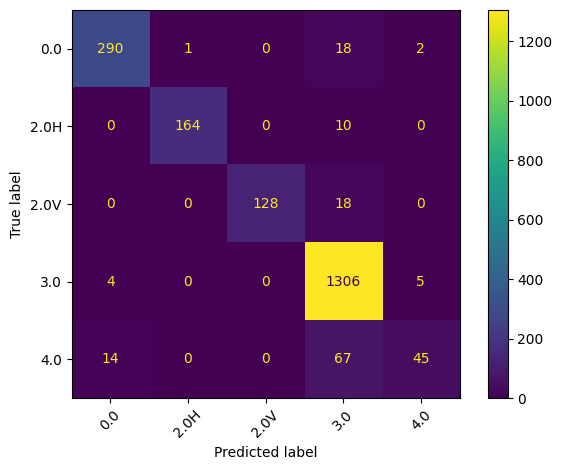

In [14]:
ALL_LABELS = sorted(y_train.unique())

proba_test = model.predict(X_test_seq)
pred_test  = np.argmax(proba_test, axis=1)
pred_test_labels = le.inverse_transform(pred_test)

proba_train = model.predict(X_train_seq)
pred_train  = np.argmax(proba_train, axis=1)
pred_train_labels = le.inverse_transform(pred_train)

print("CNN — Train")
print(classification_report(y_train_seq, pred_train_labels, digits=3))

cm = confusion_matrix(y_train_seq, pred_train_labels, labels=le.classes_)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

# “Stable gear” on the window-end labels:
print("Stable gears (CNN) — Train")
print(classification_report_when_stable_gear(pd.Series(y_train_seq), pred_train_labels))
cm_stable, labels = confusion_matrix_when_stable_gear(pd.Series(y_train_seq), pred_train_labels), le.classes_
ConfusionMatrixDisplay(cm_stable, display_labels=labels).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

print("CNN — Test")
print(classification_report(y_test_seq, pred_test_labels, digits=3))

cm = confusion_matrix(y_test_seq, pred_test_labels, labels=le.classes_)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

# “Stable gear” on the window-end labels:
print("Stable gears (CNN) — Test")
print(classification_report_when_stable_gear(pd.Series(y_test_seq), pred_test_labels))
cm_stable, labels = confusion_matrix_when_stable_gear(pd.Series(y_test_seq), pred_test_labels), le.classes_
ConfusionMatrixDisplay(cm_stable, display_labels=labels).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()